In [84]:
import sys
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

We import libraries and read the csv converted file:

In [85]:
df = pd.read_csv('real-estate-data.csv')

In [86]:
#We check whether the data has any missing values
print(df.isnull().sum())

id_              0
ward             0
beds            54
baths            0
DEN              0
size            53
parking          0
exposure         0
D_mkt           93
building_age     0
maint           45
price           61
lt               0
lg               0
dtype: int64


In [87]:
#We want to get rid of the null values by filling them with other values
x = df['size'].mode()
y = df['maint'].mean()
z = df['beds'].median()
h = df['D_mkt'].median()

In [88]:
df['size'].fillna(x.iloc[0], inplace=True)
df['maint'].fillna(y, inplace=True)
df['beds'].fillna(z, inplace=True)
df['D_mkt'].fillna(h, inplace=True)

In [89]:
#Name df2 as our "clean" data frame with no null values
df2 = df[df['price'].notna()]

In [90]:
#We check for Dtype of our features
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2981 entries, 0 to 3041
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_           2981 non-null   int64  
 1   ward          2981 non-null   object 
 2   beds          2981 non-null   float64
 3   baths         2981 non-null   int64  
 4   DEN           2981 non-null   object 
 5   size          2981 non-null   object 
 6   parking       2981 non-null   object 
 7   exposure      2981 non-null   object 
 8   D_mkt         2981 non-null   float64
 9   building_age  2981 non-null   int64  
 10  maint         2981 non-null   float64
 11  price         2981 non-null   float64
 12  lt            2981 non-null   float64
 13  lg            2981 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 349.3+ KB


Below, we convert the data in size to the average of the range, to enable the code to better represent the relation

In [91]:
#We convert object Dtype by Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
columns = ['DEN', 'parking', 'exposure']
for col in columns: df2.loc[:, col] = le.fit_transform(df2[col])
ward_mapping = {'W10': 0.0, 'W11': 0.4, 'W13': 0.8}
df2['ward'] = df2['ward'].map(ward_mapping)
def size_to_midpoint(size_str):
    # Handle ranges with a hyphen ('-')
    if '-' in size_str:
        range_parts = size_str.split('-')
        if len(range_parts) == 2:
            start = int(range_parts[0].strip())
            end_part = range_parts[1].split()[0]
            
            if end_part == '+':  # Special case for ranges like '4000+ sqft'
                # Assign a reasonable value for the "+" case, can be adjusted
                return start + 500  # Or adjust based on your expected range
            
            end = int(end_part)  # Convert to integer if valid
            midpoint = (start + end) / 2
            return midpoint
    
    # Handle single values with the "+" sign (e.g., "4000+ sqft")
    elif '+' in size_str:
        start = int(size_str.split()[0].split('+')[0].strip())
        return start + 500  # Arbitrary addition to handle the range

    return None  # In case of an unrecognized format

# Apply the function to the 'size' column
df2['size'] = df2['size'].apply(size_to_midpoint)

# Check the result
print(df2['size'].head())

0    1749.5
1     749.5
2     749.5
3     749.5
4     749.5
Name: size, dtype: float64


/tmp/ipykernel_115/178663347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ward'] = df2['ward'].map(ward_mapping)
/tmp/ipykernel_115/178663347.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['size'] = df2['size'].apply(size_to_midpoint)


In [92]:
df2

,id_,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg
0,219129,0.8,3.0,3,0,1749.5,0,1,16.0,9,1087.000000,1821000.0,43.617997,-79.392383
1,757581,0.8,1.0,1,1,749.5,1,3,23.0,3,469.000000,613000.0,43.648968,-79.390031
2,404196,0.8,2.0,2,1,749.5,1,3,12.0,1,767.000000,838000.0,43.641045,-79.375436
3,821441,0.8,2.0,2,0,749.5,1,2,10.0,25,827.000000,935000.0,43.642122,-79.370250
4,612090,0.0,2.0,1,0,749.5,0,2,5.0,1,752.529196,1328000.0,43.692210,-79.365015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,715398,0.8,2.0,2,0,1749.5,0,2,1.0,1,1183.000000,1657000.0,43.648766,-79.418944
3038,104338,0.0,1.0,1,1,249.5,0,0,2.0,11,649.000000,589000.0,43.672338,-79.377044
3039,476334,0.8,2.0,2,1,1749.5,1,1,0.0,17,1023.000000,1386000.0,43.636830,-79.412187
3040,413482,0.0,1.0,1,1,749.5,0,1,7.0,25,659.000000,774000.0,43.669317,-79.408047


In [93]:
df2.apply(pd.to_numeric)

,id_,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg
0,219129,0.8,3.0,3,0,1749.5,0,1,16.0,9,1087.000000,1821000.0,43.617997,-79.392383
1,757581,0.8,1.0,1,1,749.5,1,3,23.0,3,469.000000,613000.0,43.648968,-79.390031
2,404196,0.8,2.0,2,1,749.5,1,3,12.0,1,767.000000,838000.0,43.641045,-79.375436
3,821441,0.8,2.0,2,0,749.5,1,2,10.0,25,827.000000,935000.0,43.642122,-79.370250
4,612090,0.0,2.0,1,0,749.5,0,2,5.0,1,752.529196,1328000.0,43.692210,-79.365015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,715398,0.8,2.0,2,0,1749.5,0,2,1.0,1,1183.000000,1657000.0,43.648766,-79.418944
3038,104338,0.0,1.0,1,1,249.5,0,0,2.0,11,649.000000,589000.0,43.672338,-79.377044
3039,476334,0.8,2.0,2,1,1749.5,1,1,0.0,17,1023.000000,1386000.0,43.636830,-79.412187
3040,413482,0.0,1.0,1,1,749.5,0,1,7.0,25,659.000000,774000.0,43.669317,-79.408047


In [94]:
#Limit the values in order to eliminate outliers
Q1 = df2['price'].quantile(0.25)
Q3 = df2['price'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = df2[(df2['price'] < lower_bound) | (df2['price'] > upper_bound)]

df_cleaned = df2[(df2['price'] >= lower_bound) & (df2['price'] <= upper_bound)]

In [95]:
#After the data is clean we ove forward to preparing to train the model
X = df_cleaned.drop(columns=['price', 'id_', 'lt', 'lg'])
Y = df_cleaned['price']

In [96]:
#Separating data into training set and testing set
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.2, random_state = 42)

from sklearn.preprocessing import StandardScaler

#Scaling the data in order to use it in the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Model: DecisionTreeRegressor
MAE: 137625.2285, MSE: 32924586837.2943, R² Score: 0.6650


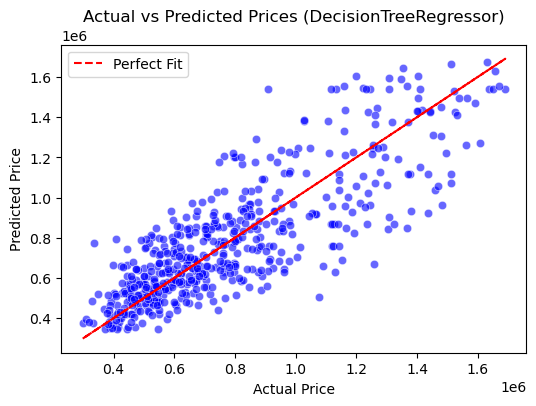

Model: Random Forest
MAE: 98535.2834, MSE: 16419714850.4570, R² Score: 0.8329


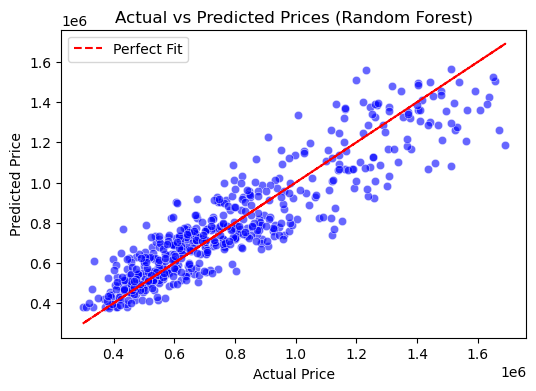

Model: KNeighborsRegressor
MAE: 107497.6234, MSE: 19195346837.2943, R² Score: 0.8047


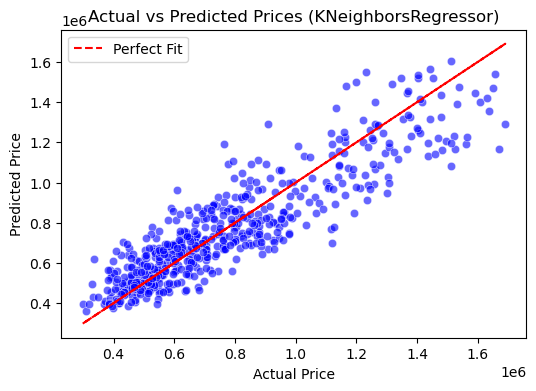

Model: Linear Regression
MAE: 99840.2076, MSE: 17044176382.8840, R² Score: 0.8266


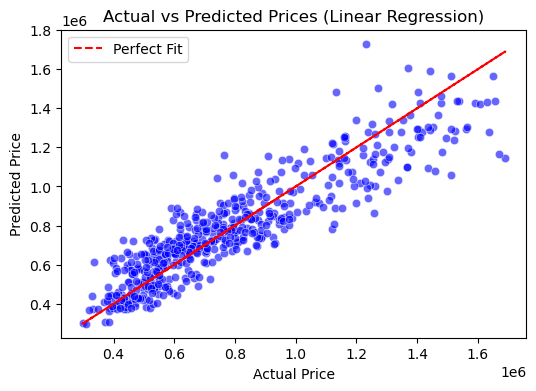

Model: Lasso
MAE: 99840.2052, MSE: 17044169438.6581, R² Score: 0.8266


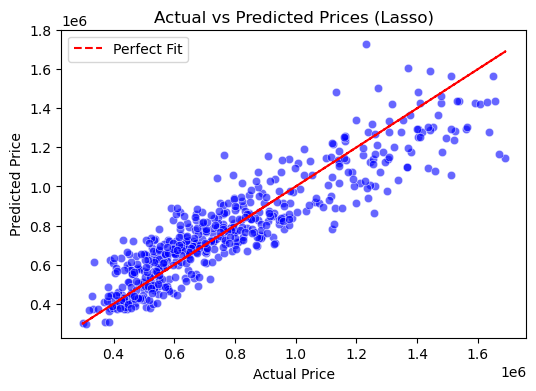

Model: MLP
MAE: 104635.6711, MSE: 17885038794.3331, R² Score: 0.8180


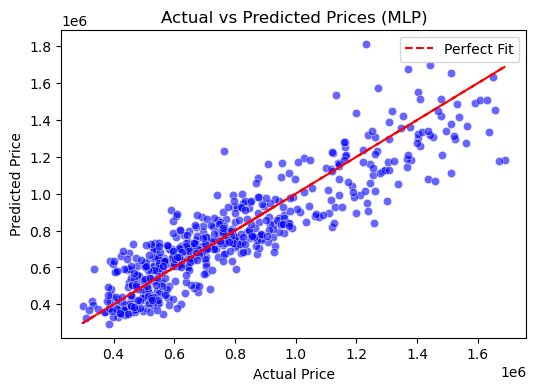

In [102]:
#Training and testing the data and then comparing the different models
models = {}

#Decision Tree Regressor
models['DecisionTreeRegressor'] = DecisionTreeRegressor()

#Random Forest Regressor
models['Random Forest'] = RandomForestRegressor()

#K-Nearest Neighbors Regressor
models['KNeighborsRegressor'] = KNeighborsRegressor()

#Linear Regression
models['Linear Regression'] = LinearRegression()

#Lasso
models['Lasso'] = Lasso(alpha=0.1)

#MLP
models['MLP'] = MLPRegressor(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='adam', max_iter=10000, random_state=42)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae, mse, r2 = {}, {}, {}

for key in models.keys():
    
    models[key].fit(X_train, Y_train)

    
    predictions = models[key].predict(X_val)

    
    mae[key] = mean_absolute_error(Y_val, predictions)
    mse[key] = mean_squared_error(Y_val, predictions)
    r2[key] = r2_score(Y_val, predictions)

    print(f'Model: {key}')
    print(f'MAE: {mae[key]:.4f}, MSE: {mse[key]:.4f}, R² Score: {r2[key]:.4f}')
    
    
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=Y_val, y=predictions, color="blue", alpha=0.6)
    plt.plot(Y_val, Y_val, color="red", linestyle="dashed", label="Perfect Fit")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs Predicted Prices ({key})")
    plt.legend()
    plt.show()



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
MAE: 94152.2962
MSE: 15240551525.8103
R² Score: 0.8449


/tmp/ipykernel_115/3029825019.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=features, palette="viridis")


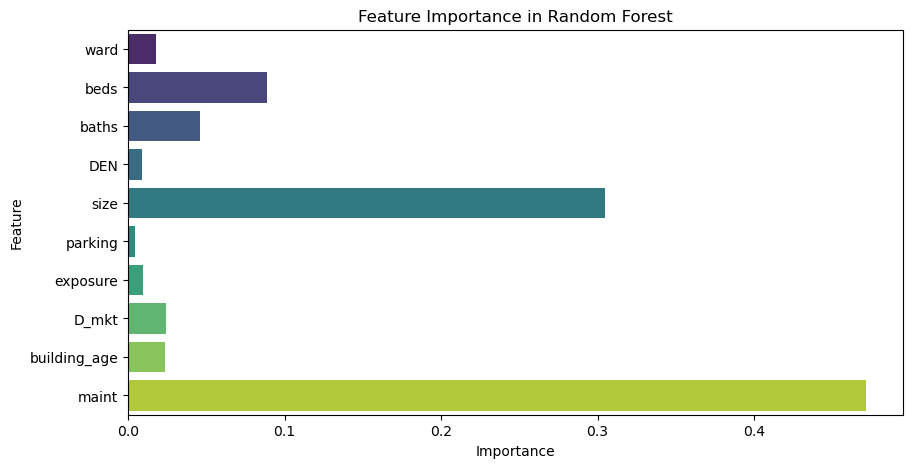

In [103]:
#Easy to observe Random Forest is the better model
#Now we search for the best hyperparameters for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],            # 3 options
    'max_depth': [None, 10, 20],                # 3 options
    'min_samples_split': [2, 5],                # 2 options
    'min_samples_leaf': [1, 2],                 # 2 options
    'max_features': ['sqrt']                   # 1 option
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)


best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Y_pred = best_rf.predict(X_val)


mae = mean_absolute_error(Y_val, Y_pred)
mse = mean_squared_error(Y_val, Y_pred)
r2 = r2_score(Y_val, Y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


feature_importance = best_rf.feature_importances_
features = df_cleaned.drop(columns=['price', 'id_', 'lt', 'lg']).columns

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=features, palette="viridis")
plt.title("Feature Importance in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

<Axes: >

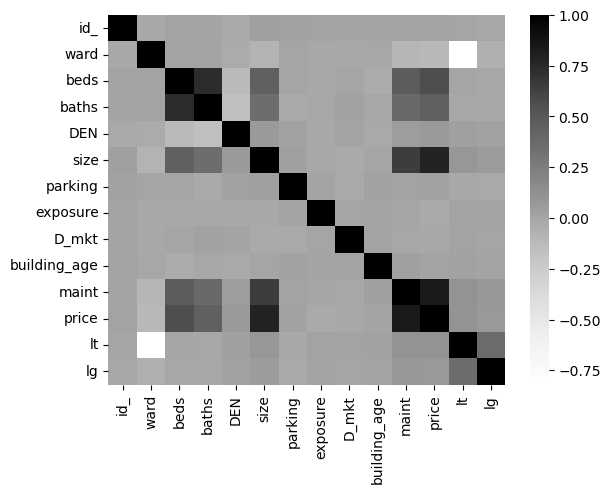

In [105]:
import seaborn as sns
sns.heatmap(df_cleaned.corr(), annot=False, cmap= 'Greys')

In [106]:
df_cleaned.corr()

,id_,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg
id_,1.000000,-0.014077,0.014165,0.005411,-0.021050,0.028113,0.019734,0.015163,0.005757,0.013991,0.009160,0.012310,-0.000222,-0.003489
ward,-0.014077,1.000000,0.015455,0.015470,-0.032961,-0.073625,0.004768,-0.009523,-0.014165,-0.008347,-0.100519,-0.105121,-0.819468,-0.062382
beds,0.014165,0.015455,1.000000,0.735615,-0.117135,0.447589,0.002272,-0.010259,0.004916,-0.035754,0.480283,0.565280,0.002160,-0.002288
baths,0.005411,0.015470,0.735615,1.000000,-0.158108,0.354524,-0.020391,-0.007139,0.022978,-0.006220,0.387375,0.449203,-0.004295,-0.015079
DEN,-0.021050,-0.032961,-0.117135,-0.158108,1.000000,0.063585,0.022364,-0.015059,0.005706,-0.021497,0.052506,0.064787,0.031530,0.023923
size,0.028113,-0.073625,0.447589,0.354524,0.063585,1.000000,0.029033,-0.011682,-0.030054,0.002627,0.650407,0.783417,0.085033,0.057412
parking,0.019734,0.004768,0.002272,-0.020391,0.022364,0.029033,1.000000,0.005912,-0.019893,0.024330,0.018831,0.021091,-0.010266,-0.023424
exposure,0.015163,-0.009523,-0.010259,-0.007139,-0.015059,-0.011682,0.005912,1.000000,-0.001811,0.008304,-0.000036,-0.023877,0.015276,0.015172
D_mkt,0.005757,-0.014165,0.004916,0.022978,0.005706,-0.030054,-0.019893,-0.001811,1.000000,0.015912,-0.003705,-0.015594,0.012773,0.004604
building_age,0.013991,-0.008347,-0.035754,-0.006220,-0.021497,0.002627,0.024330,0.008304,0.015912,1.000000,0.027378,0.005458,0.020641,0.005270


In [107]:
df_cleaned

,id_,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg
1,757581,0.8,1.0,1,1,749.5,1,3,23.0,3,469.000000,613000.0,43.648968,-79.390031
2,404196,0.8,2.0,2,1,749.5,1,3,12.0,1,767.000000,838000.0,43.641045,-79.375436
3,821441,0.8,2.0,2,0,749.5,1,2,10.0,25,827.000000,935000.0,43.642122,-79.370250
4,612090,0.0,2.0,1,0,749.5,0,2,5.0,1,752.529196,1328000.0,43.692210,-79.365015
5,190492,0.0,0.0,1,0,749.5,1,2,1.0,12,526.000000,645000.0,43.653316,-79.400309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,715398,0.8,2.0,2,0,1749.5,0,2,1.0,1,1183.000000,1657000.0,43.648766,-79.418944
3038,104338,0.0,1.0,1,1,249.5,0,0,2.0,11,649.000000,589000.0,43.672338,-79.377044
3039,476334,0.8,2.0,2,1,1749.5,1,1,0.0,17,1023.000000,1386000.0,43.636830,-79.412187
3040,413482,0.0,1.0,1,1,749.5,0,1,7.0,25,659.000000,774000.0,43.669317,-79.408047


In [108]:
# Calculate the median, mean, and range for price by DEN
den_stats = df.groupby('DEN')['price'].describe()

print(den_stats)


      count           mean            std       min       25%       50%  \
DEN                                                                       
No   1913.0  875400.418191  554087.792728  298000.0  522000.0  685000.0   
YES  1068.0  925702.247191  563832.046515  348000.0  606000.0  750000.0   

           75%        max  
DEN                        
No   1028000.0  4349000.0  
YES   986000.0  5688000.0  


In [109]:
df_cleaned.head()

,id_,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg
1,757581,0.8,1.0,1,1,749.5,1,3,23.0,3,469.000000,613000.0,43.648968,-79.390031
2,404196,0.8,2.0,2,1,749.5,1,3,12.0,1,767.000000,838000.0,43.641045,-79.375436
3,821441,0.8,2.0,2,0,749.5,1,2,10.0,25,827.000000,935000.0,43.642122,-79.370250
4,612090,0.0,2.0,1,0,749.5,0,2,5.0,1,752.529196,1328000.0,43.692210,-79.365015
5,190492,0.0,0.0,1,0,749.5,1,2,1.0,12,526.000000,645000.0,43.653316,-79.400309


In [114]:
input_data = {
    'ward': [0.8],
    'beds': [1.0],           # Number of beds
    'baths': [1],            # Number of baths
    'DEN': [1],          # DEN (Assuming 1 means it has a den)
    'size': [749.5],             # Size (in square meters)
    'parking': [1],          # Parking spaces (assuming 1 means 1 parking space)
    'exposure': [3],         # Exposure (this should be a numerical encoding of the original value)
    'D_mkt': [23.0],         # Market demand (value already numeric)
    'building_age': [3],
    'maint': [469.0]# Age of the building (in years)      # Maintenance (Assumed to be continuous)
}

# Create DataFrame
input_df = pd.DataFrame(input_data)

In [115]:
input_df

,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint
0,0.8,1.0,1,1,749.5,1,3,23.0,3,469.0


In [117]:
predicted_price = best_rf.predict(input_df)

# Print the predicted price
print(f"Predicted price: {predicted_price[0]:.2f}")

Predicted price: 636931.11


In [118]:
df_cleaned.head(15)

,id_,ward,beds,baths,DEN,size,parking,exposure,D_mkt,building_age,maint,price,lt,lg
1,757581,0.8,1.0,1,1,749.5,1,3,23.0,3,469.000000,613000.0,43.648968,-79.390031
2,404196,0.8,2.0,2,1,749.5,1,3,12.0,1,767.000000,838000.0,43.641045,-79.375436
3,821441,0.8,2.0,2,0,749.5,1,2,10.0,25,827.000000,935000.0,43.642122,-79.370250
4,612090,0.0,2.0,1,0,749.5,0,2,5.0,1,752.529196,1328000.0,43.692210,-79.365015
5,190492,0.0,0.0,1,0,749.5,1,2,1.0,12,526.000000,645000.0,43.653316,-79.400309
6,194328,0.4,1.0,1,1,749.5,0,2,4.0,8,610.000000,777000.0,43.665732,-79.371468
7,463115,0.8,1.0,2,1,749.5,0,3,5.0,4,639.000000,778000.0,43.638118,-79.387741
8,697209,0.8,2.0,1,1,749.5,1,1,40.0,7,705.000000,776000.0,43.633506,-79.404315
10,932951,0.8,1.0,1,1,749.5,1,0,19.0,0,588.000000,664000.0,43.634875,-79.425289
11,314167,0.4,3.0,2,0,749.5,1,3,37.0,19,492.000000,664000.0,43.659624,-79.356748


In [128]:
input_data = {
    'ward': [0.0],
    'beds': [3.0],           # Number of beds
    'baths': [1],            # Number of baths
    'DEN': [0],          # DEN (Assuming 1 means it has a den)
    'size': [749.5],             # Size (in square meters)
    'parking': [0],          # Parking spaces (assuming 1 means 1 parking space)
    'exposure': [2],         # Exposure (this should be a numerical encoding of the original value)
    'D_mkt': [5.0],         # Market demand (value already numeric)
    'building_age': [1],
    'maint': [752.529196]# Age of the building (in years)         # Maintenance (Assumed to be continuous)
}

# Create DataFrame
input_df = pd.DataFrame(input_data)

In [129]:
predicted_price = best_rf.predict(input_df)

# Print the predicted price
print(f"Predicted price: {predicted_price[0]:.2f}")

Predicted price: 1057021.01


In [130]:
# Calculate the correlation between 'maint' and 'price' in df_cleaned
correlation = df_cleaned[['maint', 'price']].corr()

# Print the correlation matrix
print(correlation)


          maint     price
maint  1.000000  0.840694
price  0.840694  1.000000
